In [6]:
pip install numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Data type: float64
Target type: int64


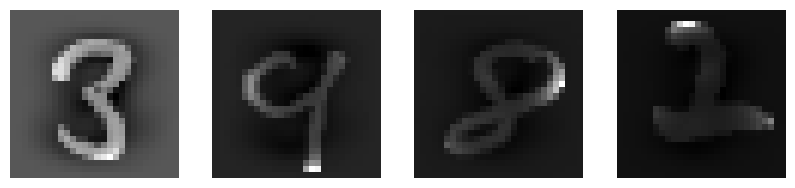

In [14]:
import pandas as pd
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

# Check if X is a DataFrame and convert if necessary
if isinstance(X, pd.DataFrame):
    X = X.to_numpy()
if isinstance(y, pd.Series):
    y = y.to_numpy().astype(int)  # Ensure y is numpy array and type int

# Filter the data for digits 2, 3, 8, 9
selected_digits = [2, 3, 8, 9]
mask = np.isin(y, selected_digits)
X, y = X[mask], y[mask]

# Reset the index if y is a pandas Series
if isinstance(y, pd.Series):
    y.reset_index(drop=True, inplace=True)

# Balance the data for equal class representation
def balance_data(X, y, samples_per_class):
    unique_classes = np.unique(y)
    indices = []
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        selected_indices = np.random.choice(cls_indices, samples_per_class, replace=False)
        indices.extend(selected_indices)
    return X[indices], y[indices]

# Set the number of samples per class for training and test sets
samples_per_class = 5000
X_balanced, y_balanced = balance_data(X, y, samples_per_class)

# Split into training and test sets using a proportion for the training size
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, 
    train_size=0.8333,  # This represents roughly 20,000 samples if the total is 24,000
    random_state=42, 
    stratify=y_balanced
)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check data types
print("Data type:", X_train.dtype)
print("Target type:", y_train.dtype)

# Function to plot sample images directly with NumPy arrays
def plot_digits(data):
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for ax, image in zip(axes, data):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

# Plot sample images without needing to call .values
plot_digits(X_train[:4])

In [15]:
pip install cvxopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 1.5 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [17]:
from cvxopt import matrix, solvers

def train_svm(X, y, C=1):
    n_samples, n_features = X.shape
    
    # Adjust the regularization parameter and add bias handling directly within the optimization
    P = matrix(np.block([
        [np.eye(n_features), np.zeros((n_features, 1))],
        [np.zeros((1, n_features)), np.zeros((1, 1))]
    ]))
    q = matrix(np.hstack([np.zeros(n_features + 1), C * np.ones(n_samples)]))
    
    # Set up the G and h matrices for inequality constraints
    G_top = np.hstack([-y[:, np.newaxis] * X, -y[:, np.newaxis], -np.eye(n_samples)])
    G_bottom = np.hstack([np.zeros((n_samples, n_features + 1)), -np.eye(n_samples)])
    G = matrix(np.vstack([G_top, G_bottom]))

    h = matrix(np.hstack([-np.ones(n_samples), np.zeros(n_samples)]))
    
    # Solve the quadratic programming problem
    solvers.options['show_progress'] = True  # Enable progress output
    solvers.options['abstol'] = 1e-10  # Set higher accuracy
    solvers.options['reltol'] = 1e-10  # Set higher accuracy
    solvers.options['feastol'] = 1e-10  # Set higher feasibility tolerance
    solution = solvers.qp(P, q, G, h)
    
    # Extract weights and bias
    w = np.array(solution['x'][:n_features])
    b = np.array(solution['x'][n_features])

    return w, b

# Prepare one-vs-all classifiers
classifiers = {}
selected_digits = [2, 3, 8, 9]  # Assuming you have these digits only
for digit in selected_digits:
    y_binary = np.where(y_train == digit, 1, -1)
    w, b = train_svm(X_train, y_binary, C=0.1)  # Using a smaller C for simplicity
    classifiers[digit] = (w, b)

def predict(X, classifiers):
    results = {digit: X.dot(w) + b for digit, (w, b) in classifiers.items()}
    return np.array([max(results, key=results.get) for _ in X])

# Prediction
predictions = predict(X_test, classifiers)

TypeError: 'P' must be a 'd' matrix of size (17451, 17451)